In [126]:
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

In [127]:
os.environ["HOPSWORKS_API_KEY"] = "WMg6iOTOV75YfUcb.AcuNGWjcMS79s4bz0FqZsRaJtcU8Siqu7Mx084dfkRHauMxK251VTYLYSBAIqBb5"
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-08 17:17:33,899 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 17:17:33,905 INFO: Initializing external client
2025-01-08 17:17:33,905 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 17:17:35,317 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1168537


In [128]:
data_fg = fs.get_feature_group(
    name='data_historic',
    version=1,
)
df = data_fg.read()
last_hour = df.sort_values('timestamp', ascending=False).head(1)
print(last_hour)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
                timestamp  inflation_rate    open    high     low  gold_price  \
8765  2025-01-08 16:00:00         0.03888  2666.0  2672.0  2661.0      2671.0   

      volume  
8765  63.189  


In [129]:
proj = project.get_model_registry()
model_hopworks = proj.get_model(
    name="gold_final_final",
    version=1,
)
_model = model_hopworks.download()
my_model = XGBRegressor()
my_model.load_model(_model + "/model.json")
my_model

XGBRegressor(base_score='2.3913245E3', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [130]:
time = last_hour['timestamp']
last_hour.drop(columns='timestamp', inplace=True)
last_hour.drop(columns='gold_price', inplace=True)
print(last_hour)


      inflation_rate    open    high     low  volume
8765         0.03888  2666.0  2672.0  2661.0  63.189


In [131]:
price_pred = my_model.predict(last_hour[['inflation_rate', 'open', 'high','low', 'volume']])
time = pd.to_datetime(time)
time = time + timedelta(hours=1)
print(time)



8765   2025-01-08 17:00:00
Name: timestamp, dtype: datetime64[ns]


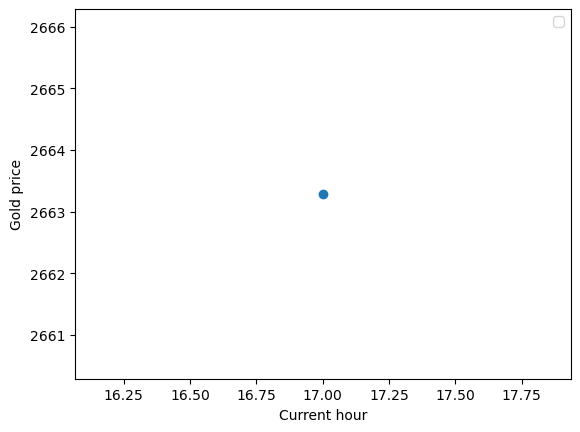

In [132]:
h = str(time.dt.hour.tolist()[0])
plt.plot(time.dt.hour, price_pred, marker='o')
plt.xlabel('Current hour')
plt.ylabel('Gold price')
plt.ylim(price_pred - 3, price_pred + 3)
plt.legend()
plt.savefig("docs/plot" + h + ".png")
plt.show()